# 레이아웃 이미지 학습 데이터 추출 파이프라인 (배치 처리)

이 노트북에서는 **폴더 내 모든 이미지**를 자동으로 처리하여 학습용 데이터를 추출합니다.

## 주요 기능
- ✅ **배치 처리**: 폴더 내 모든 이미지 자동 처리
- ✅ **이식성**: 모든 OS(Windows/Mac/Linux)에서 실행 가능
- ✅ **자동 경로 설정**: 노트북 위치 기준 자동 설정
- ✅ **진행 상황 표시**: tqdm으로 실시간 진행률
- ✅ **통합 통계**: 전체 데이터셋 통계

## 디렉토리 구조
```
project_root/                    # 이 노트북이 있는 폴더
├── layout_extraction_pipeline_batch.ipynb
├── input_images/                # 처리할 이미지 폴더
│   ├── layout_001.png
│   ├── layout_002.jpg
│   └── ...
└── output_batch/                # 결과 저장 폴더
    ├── summary_statistics.json
    ├── image_1/
    └── yolo_dataset/
```

## 1. 환경 설정 및 패키지 설치

In [3]:
# 필수 패키지 설치
import subprocess
import sys

def install_packages():
    """레이아웃 이미지 처리에 필요한 패키지 설치"""
    packages = [
        'opencv-python',
        'numpy',
        'matplotlib',
        'pillow',
        'pandas',
        'tqdm',
        'seaborn',
    ]
    
    for package in packages:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
    
    print("\n✅ 모든 패키지 설치 완료!")

# 패키지 설치 (처음 실행 시 주석 해제)
install_packages()

Installing opencv-python...
Installing numpy...
Installing matplotlib...
Installing pillow...
Installing pandas...
Installing tqdm...
Installing seaborn...

✅ 모든 패키지 설치 완료!


## 2. 라이브러리 임포트 및 환경 확인

In [4]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass, asdict
from tqdm import tqdm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Matplotlib 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

print("=" * 60)
print("실행 환경 정보")
print("=" * 60)
print(f"Python 버전: {sys.version}")
print(f"OpenCV 버전: {cv2.__version__}")
print(f"NumPy 버전: {np.__version__}")
print(f"작업 디렉토리: {Path.cwd()}")
print("\n✅ 라이브러리 임포트 완료")

실행 환경 정보
Python 버전: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
OpenCV 버전: 4.12.0
NumPy 버전: 2.2.6
작업 디렉토리: C:\Users\user\Documents\lab\files

✅ 라이브러리 임포트 완료


## 3. 프로젝트 디렉토리 구조 설정

노트북 위치를 기준으로 자동으로 경로를 설정합니다.

In [5]:
# 프로젝트 루트 디렉토리 (노트북이 있는 위치)
PROJECT_ROOT = Path.cwd()

# 주요 디렉토리 정의
INPUT_DIR = PROJECT_ROOT / 'input_images'      # 입력 이미지 폴더
OUTPUT_DIR = PROJECT_ROOT / 'output_batch'     # 출력 결과 폴더
YOLO_DIR = OUTPUT_DIR / 'yolo_dataset'         # YOLO 데이터셋 폴더

# YOLO 하위 디렉토리
YOLO_IMAGES_TRAIN = YOLO_DIR / 'images' / 'train'
YOLO_LABELS_TRAIN = YOLO_DIR / 'labels' / 'train'

print("=" * 60)
print("프로젝트 디렉토리 구조")
print("=" * 60)
print(f"프로젝트 루트: {PROJECT_ROOT}")
print(f"입력 폴더: {INPUT_DIR.relative_to(PROJECT_ROOT)}")
print(f"출력 폴더: {OUTPUT_DIR.relative_to(PROJECT_ROOT)}")
print(f"\n💡 TIP: 처리할 이미지를 '{INPUT_DIR.name}' 폴더에 넣으세요!")

프로젝트 디렉토리 구조
프로젝트 루트: C:\Users\user\Documents\lab\files
입력 폴더: input_images
출력 폴더: output_batch

💡 TIP: 처리할 이미지를 'input_images' 폴더에 넣으세요!


In [6]:
# 필수 디렉토리 생성
directories = [
    INPUT_DIR,
    OUTPUT_DIR,
    YOLO_IMAGES_TRAIN,
    YOLO_LABELS_TRAIN,
]

print("\n디렉토리 생성 중...")
for dir_path in directories:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"  ✓ {dir_path.relative_to(PROJECT_ROOT)}")

print("\n✅ 모든 디렉토리 생성 완료!")


디렉토리 생성 중...
  ✓ input_images
  ✓ output_batch
  ✓ output_batch\yolo_dataset\images\train
  ✓ output_batch\yolo_dataset\labels\train

✅ 모든 디렉토리 생성 완료!


## 4. 레이아웃 설정 (필요시 수정)

실제 레이아웃 크기를 입력하세요.

In [7]:
# ========================================
# 레이아웃 설정 (필요시 여기만 수정)
# ========================================

REAL_WIDTH = 120.0   # 실제 가로 크기 (미터)
REAL_HEIGHT = 48.0   # 실제 세로 크기 (미터)

print("=" * 60)
print("레이아웃 설정")
print("=" * 60)
print(f"실제 크기: {REAL_WIDTH}m x {REAL_HEIGHT}m")
print("\n💡 크기가 다른 경우 위 셀의 값을 수정하세요!")

레이아웃 설정
실제 크기: 120.0m x 48.0m

💡 크기가 다른 경우 위 셀의 값을 수정하세요!


## 5. 색상 범위 정의

In [27]:
# 색상 범위 정의 (HSV 색공간)
COLOR_RANGES = {
    'booth': {
        'id': 0,
        'name': '부스',
        'color_rgb': (200, 0, 0),
        'hsv_ranges': [
            {'lower': np.array([0, 100, 100]), 'upper': np.array([10, 255, 255])},
            {'lower': np.array([160, 100, 100]), 'upper': np.array([180, 255, 255])}
        ]
    },
    'stage': {
        'id': 1,
        'name': '무대',
        'color_rgb': (0, 100, 200),
        'hsv_ranges': [
            {'lower': np.array([100, 100, 50]), 'upper': np.array([130, 255, 255])}
        ]
    },
    'exit': {
        'id': 2,
        'name': '출구',
        'color_rgb': (255, 0, 255),
        'hsv_ranges': [
            {'lower': np.array([130, 100, 100]), 'upper': np.array([160, 255, 255])}
        ]
    },
    'entrance': {
        'id': 3,
        'name': '입구',
        'color_rgb': (255, 100, 150),
        'hsv_ranges': [
            {'lower': np.array([160, 30, 100]), 'upper': np.array([180, 100, 255])}
        ]
    },
    'restroom': {
        'id': 4,
        'name': '화장실',
        'color_rgb': (0, 200, 0),
        'hsv_ranges': [
            {'lower': np.array([40, 50, 50]), 'upper': np.array([80, 255, 255])}
        ]
    },
    'food_area': {
        'id': 5,
        'name': '음식구역',
        'color_rgb': (0, 200, 200),
        'hsv_ranges': [
            {'lower': np.array([80, 100, 100]), 'upper': np.array([100, 255, 255])}
        ]
    },
    'seating': {
        'id': 6,
        'name': '객석',
        'color_rgb': (200, 200, 0),
        'hsv_ranges': [
            {'lower': np.array([20, 100, 100]), 'upper': np.array([30, 255, 255])}
        ]
    },
    'system': {
        'id': 7,
        'name': '시스템',
        'color_rgb': (255, 140, 0),
        'hsv_ranges': [
            {'lower': np.array([10, 100, 100]), 'upper': np.array([20, 255, 255])}
        ]
    },
    'boundary': {
        'id': 8,
        'name': '경계선',
        'color_rgb': (139, 69, 19),
        'hsv_ranges': [
            {'lower': np.array([10, 100, 20]), 'upper': np.array([20, 255, 100])}
        ]
    },
    'other': {
        'id': 9,
        'name': '기타',
        'color_rgb': (128, 128, 128),
        'hsv_ranges': [
            {'lower': np.array([0, 0, 50]), 'upper': np.array([180, 30, 200])}
        ]
    }
}

print("✅ 색상 범위 정의 완료")
print(f"총 {len(COLOR_RANGES)}개 클래스 정의됨\n")

for class_name, info in COLOR_RANGES.items():
    print(f"  {info['id']}: {info['name']} ({class_name})")

✅ 색상 범위 정의 완료
총 11개 클래스 정의됨

  0: 부스 (booth)
  1: 무대 (stage)
  2: 출구 (exit)
  3: 입구 (entrance)
  4: 화장실 (restroom)
  5: 음식구역 (food_area)
  6: 객석 (seating)
  7: 시스템 (system)
  8: 경계선 (boundary)
  9: 기타 (other)
  10: 출연진대기실 (backstage)


## 6. 데이터 클래스 및 추출기

In [28]:
@dataclass
class LayoutObject:
    """레이아웃 객체 데이터 클래스"""
    class_id: int
    class_name: str
    shape: str
    x: float
    y: float
    width: Optional[float] = None
    height: Optional[float] = None
    radius: Optional[float] = None
    rotation: Optional[float] = None
    confidence: float = 1.0
    label: Optional[str] = None
    
    def to_dict(self):
        return asdict(self)


class LayoutExtractor:
    """색상 기반 레이아웃 객체 추출기"""
    
    def __init__(self, image_path: Path, real_width: float = 120.0, real_height: float = 48.0):
        self.image_path = image_path
        self.image = cv2.imread(str(image_path))
        
        if self.image is None:
            raise ValueError(f"이미지를 불러올 수 없습니다: {image_path}")
        
        self.image_rgb = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        self.hsv = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        
        self.real_width = real_width
        self.real_height = real_height
        
        self.layout_bounds = self._find_layout_bounds()
        self.px_to_meter_x = self.real_width / self.layout_bounds['width']
        self.px_to_meter_y = self.real_height / self.layout_bounds['height']
        
        self.objects = []
        
    def _find_layout_bounds(self) -> Dict:
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            max_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(max_contour)
            return {'x': x, 'y': y, 'width': w, 'height': h}
        
        return {'x': 0, 'y': 0, 'width': self.image.shape[1], 'height': self.image.shape[0]}
    
    def _pixel_to_meter(self, px_x: float, px_y: float) -> Tuple[float, float]:
        rel_x = (px_x - self.layout_bounds['x']) * self.px_to_meter_x
        rel_y = (px_y - self.layout_bounds['y']) * self.px_to_meter_y
        return rel_x, rel_y
    
    def _create_mask(self, color_ranges: List[Dict]) -> np.ndarray:
        mask = np.zeros(self.hsv.shape[:2], dtype=np.uint8)
        
        for range_info in color_ranges:
            temp_mask = cv2.inRange(self.hsv, range_info['lower'], range_info['upper'])
            mask = cv2.bitwise_or(mask, temp_mask)
        
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        
        return mask
    
    def extract_class(self, class_name: str, color_info: Dict) -> List[LayoutObject]:
        """특정 클래스의 객체 추출 - 모두 사각형으로 처리"""
        mask = self._create_mask(color_info['hsv_ranges'])
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        objects = []
        
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < 50:  # 최소 크기 줄임 (100 → 50)
                continue
            
            # 바운딩 박스
            x, y, w, h = cv2.boundingRect(contour)
            center_x = x + w / 2
            center_y = y + h / 2
            
            # 미터 단위로 변환
            real_x, real_y = self._pixel_to_meter(center_x, center_y)
            real_w = w * self.px_to_meter_x
            real_h = h * self.px_to_meter_y
            
            # ✅ 모든 객체를 사각형으로 처리 (원형 로직 완전 제거)
            obj = LayoutObject(
                class_id=color_info['id'],
                class_name=class_name,
                shape='rectangle',  # 항상 사각형
                x=round(real_x, 2),
                y=round(real_y, 2),
                width=round(real_w, 2),
                height=round(real_h, 2)
            )
            
            objects.append(obj)
        
        return objects
    
    def extract_all(self, verbose: bool = False) -> List[LayoutObject]:
        self.objects = []
        
        for class_name, color_info in COLOR_RANGES.items():
            class_objects = self.extract_class(class_name, color_info)
            self.objects.extend(class_objects)
            if verbose:
                print(f"  - {color_info['name']}: {len(class_objects)}개")
        
        return self.objects

print("✅ LayoutExtractor 클래스 정의 완료")

✅ LayoutExtractor 클래스 정의 완료


## 7. 배치 처리기

In [29]:
class BatchProcessor:
    """여러 이미지를 배치로 처리하는 클래스"""
    
    def __init__(self, input_dir: Path, output_dir: Path, 
                 real_width: float = 120.0, real_height: float = 48.0):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        self.real_width = real_width
        self.real_height = real_height
        
        # 지원 이미지 확장자
        self.image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
        
        self.results = []
        self.errors = []
        
    def find_images(self) -> List[Path]:
        """입력 디렉토리에서 모든 이미지 찾기"""
        images = set()
        for ext in self.image_extensions:
            images.update(self.input_dir.glob(f'*{ext}'))
            images.update(self.input_dir.glob(f'*{ext.upper()}'))
        return sorted(list(images))
    
    def process_single_image(self, image_path: Path) -> Dict:
        """단일 이미지 처리"""
        try:
            extractor = LayoutExtractor(
                image_path,
                real_width=self.real_width,
                real_height=self.real_height
            )
            
            objects = extractor.extract_all(verbose=False)
            
            image_name = image_path.stem
            output_subdir = self.output_dir / image_name
            output_subdir.mkdir(exist_ok=True)
            
            # JSON 저장
            json_data = {
                'metadata': {
                    'source_image': str(image_path),
                    'image_name': image_name,
                    'image_size': {
                        'width': extractor.image.shape[1],
                        'height': extractor.image.shape[0]
                    },
                    'layout_size': {
                        'width': self.real_width,
                        'height': self.real_height,
                        'unit': 'meters'
                    },
                    'num_objects': len(objects),
                    'timestamp': datetime.now().isoformat()
                },
                'classes': {
                    name: {
                        'id': info['id'],
                        'name': info['name'],
                        'color': info['color_rgb']
                    } for name, info in COLOR_RANGES.items()
                },
                'objects': [obj.to_dict() for obj in objects]
            }
            
            json_path = output_subdir / f'{image_name}.json'
            with open(json_path, 'w', encoding='utf-8') as f:
                json.dump(json_data, f, ensure_ascii=False, indent=2)
            
            # 재구성 이미지 생성
            reconstructed = self._render_layout(objects, extractor)
            reconstructed_path = output_subdir / f'{image_name}_reconstructed.png'
            cv2.imwrite(str(reconstructed_path), reconstructed)
            
            # 비교 이미지 생성
            comparison = self._create_comparison(extractor.image, reconstructed)
            comparison_path = output_subdir / f'{image_name}_comparison.png'
            cv2.imwrite(str(comparison_path), comparison)
            
            return {
                'image_name': image_name,
                'status': 'success',
                'num_objects': len(objects),
                'output_dir': str(output_subdir),
                'objects': objects
            }
            
        except Exception as e:
            return {
                'image_name': image_path.name,
                'status': 'error',
                'error': str(e)
            }
    
    def _render_layout(self, objects: List[LayoutObject], extractor: LayoutExtractor) -> np.ndarray:
        scale = 10
        img_width = int(self.real_width * scale)
        img_height = int(self.real_height * scale)
        
        image = np.ones((img_height, img_width, 3), dtype=np.uint8) * 255
        
        for obj in objects:
            color = COLOR_RANGES[obj.class_name]['color_rgb']
            color_bgr = (color[2], color[1], color[0])
            
            x_px = int(obj.x * scale)
            y_px = int(obj.y * scale)
            
            if obj.shape == 'rectangle':
                w_px = int(obj.width * scale)
                h_px = int(obj.height * scale)
                x1 = x_px - w_px // 2
                y1 = y_px - h_px // 2
                x2 = x_px + w_px // 2
                y2 = y_px + h_px // 2
                cv2.rectangle(image, (x1, y1), (x2, y2), color_bgr, -1)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 0), 1)
            elif obj.shape == 'circle':
                radius_px = int(obj.radius * scale)
                cv2.circle(image, (x_px, y_px), radius_px, color_bgr, -1)
                cv2.circle(image, (x_px, y_px), radius_px, (0, 0, 0), 1)
        
        cv2.rectangle(image, (0, 0), (img_width-1, img_height-1), (0, 0, 0), 2)
        return image
    
    def _create_comparison(self, original: np.ndarray, reconstructed: np.ndarray) -> np.ndarray:
        reconstructed_resized = cv2.resize(reconstructed, 
                                           (original.shape[1], original.shape[0]),
                                           interpolation=cv2.INTER_NEAREST)
        comparison = np.hstack([original, reconstructed_resized])
        return comparison
    
    def process_all(self) -> Dict:
        """모든 이미지 배치 처리"""
        images = self.find_images()
        
        if not images:
            print(f"❌ {self.input_dir}에서 이미지를 찾을 수 없습니다.")
            return {'total': 0, 'success': 0, 'error': 0}
        
        print(f"\n📁 입력 디렉토리: {self.input_dir.relative_to(PROJECT_ROOT)}")
        print(f"📁 출력 디렉토리: {self.output_dir.relative_to(PROJECT_ROOT)}")
        print(f"🖼️  발견된 이미지: {len(images)}개\n")
        
        for image_path in tqdm(images, desc="이미지 처리 중"):
            result = self.process_single_image(image_path)
            
            if result['status'] == 'success':
                self.results.append(result)
            else:
                self.errors.append(result)
        
        self._create_summary_statistics()
        
        return {
            'total': len(images),
            'success': len(self.results),
            'error': len(self.errors),
            'results': self.results,
            'errors': self.errors
        }
    
    def _create_summary_statistics(self):
        if not self.results:
            return
        
        total_class_counts = {class_name: 0 for class_name in COLOR_RANGES.keys()}
        
        for result in self.results:
            for obj in result['objects']:
                total_class_counts[obj.class_name] += 1
        
        summary = {
            'summary': {
                'total_images': len(self.results),
                'total_objects': sum(total_class_counts.values()),
                'timestamp': datetime.now().isoformat()
            },
            'class_statistics': {
                name: {
                    'count': total_class_counts[name],
                    'percentage': round(total_class_counts[name] / sum(total_class_counts.values()) * 100, 2) if sum(total_class_counts.values()) > 0 else 0
                } for name in COLOR_RANGES.keys()
            },
            'per_image_statistics': [
                {
                    'image_name': result['image_name'],
                    'num_objects': result['num_objects']
                } for result in self.results
            ]
        }
        
        summary_path = self.output_dir / 'summary_statistics.json'
        with open(summary_path, 'w', encoding='utf-8') as f:
            json.dump(summary, f, ensure_ascii=False, indent=2)
        
        print(f"\n✅ 통합 통계 저장: {summary_path.relative_to(PROJECT_ROOT)}")

print("✅ BatchProcessor 클래스 정의 완료")

✅ BatchProcessor 클래스 정의 완료


## 8. 배치 처리 실행

모든 이미지를 자동으로 처리합니다.

In [30]:
# 배치 처리기 생성
processor = BatchProcessor(
    input_dir=INPUT_DIR,
    output_dir=OUTPUT_DIR,
    real_width=REAL_WIDTH,
    real_height=REAL_HEIGHT
)

# 모든 이미지 처리
summary = processor.process_all()

print("\n" + "="*60)
print("배치 처리 완료")
print("="*60)
print(f"\n📊 처리 결과:")
print(f"  - 전체 이미지: {summary['total']}개")
print(f"  - 성공: {summary['success']}개")
print(f"  - 실패: {summary['error']}개")

if summary['error'] > 0:
    print(f"\n❌ 실패한 이미지:")
    for error in summary['errors']:
        print(f"  - {error['image_name']}: {error['error']}")


📁 입력 디렉토리: input_images
📁 출력 디렉토리: output_batch
🖼️  발견된 이미지: 13개



이미지 처리 중: 100%|██████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


✅ 통합 통계 저장: output_batch\summary_statistics.json

배치 처리 완료

📊 처리 결과:
  - 전체 이미지: 13개
  - 성공: 13개
  - 실패: 0개


## 9. 결과 분석 및 시각화

In [32]:
# 전체 통계 로드
summary_path = OUTPUT_DIR / 'summary_statistics.json'
if summary_path.exists():
    with open(summary_path, 'r', encoding='utf-8') as f:
        stats = json.load(f)
    
    print("\n=== 전체 데이터셋 통계 ===")
    print(f"총 이미지 수: {stats['summary']['total_images']}")
    print(f"총 객체 수: {stats['summary']['total_objects']}")
    print("\n클래스별 객체 수:")
    
    for class_name, class_stats in stats['class_statistics'].items():
        if class_stats['count'] > 0:
            print(f"  - {COLOR_RANGES[class_name]['name']}: {class_stats['count']}개 ({class_stats['percentage']}%)")
else:
    print("통계 파일을 찾을 수 없습니다.")


=== 전체 데이터셋 통계 ===
총 이미지 수: 13
총 객체 수: 2358

클래스별 객체 수:
  - 부스: 1705개 (72.31%)
  - 무대: 40개 (1.7%)
  - 출구: 24개 (1.02%)
  - 화장실: 29개 (1.23%)
  - 객석: 169개 (7.17%)
  - 시스템: 11개 (0.47%)
  - 기타: 260개 (11.03%)
  - 출연진대기실: 120개 (5.09%)


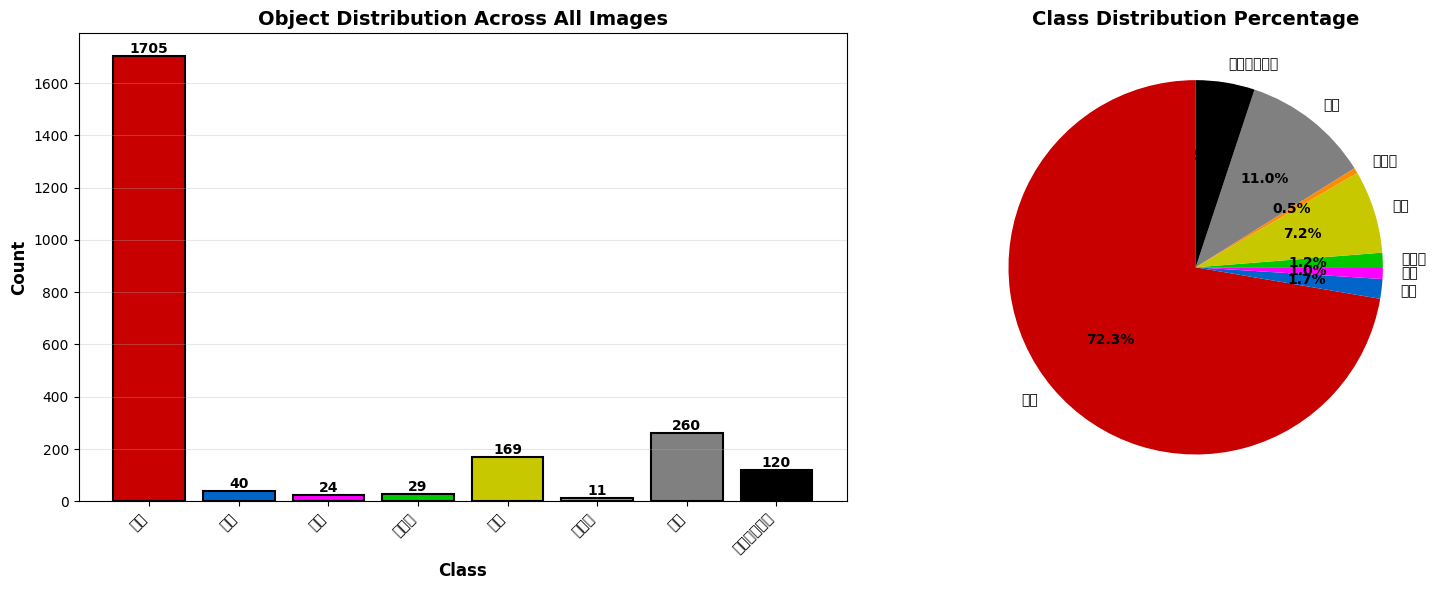

✅ 통계 차트 저장: output_batch\overall_statistics.png


In [33]:
# 클래스별 분포 시각화
if summary_path.exists() and stats['summary']['total_objects'] > 0:
    class_names = []
    class_counts = []
    class_colors = []
    
    for class_name, class_stats in stats['class_statistics'].items():
        if class_stats['count'] > 0:
            class_names.append(COLOR_RANGES[class_name]['name'])
            class_counts.append(class_stats['count'])
            color_rgb = COLOR_RANGES[class_name]['color_rgb']
            class_colors.append(tuple(c/255 for c in color_rgb))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # 막대 차트
    bars = ax1.bar(class_names, class_counts, color=class_colors, 
                   edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Class', fontsize=12, weight='bold')
    ax1.set_ylabel('Count', fontsize=12, weight='bold')
    ax1.set_title('Object Distribution Across All Images', fontsize=14, weight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=10, weight='bold')
    
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # 파이 차트
    ax2.pie(class_counts, labels=class_names, colors=class_colors, 
            autopct='%1.1f%%', startangle=90, 
            textprops={'fontsize': 10, 'weight': 'bold'})
    ax2.set_title('Class Distribution Percentage', fontsize=14, weight='bold')
    
    plt.tight_layout()
    chart_path = OUTPUT_DIR / 'overall_statistics.png'
    plt.savefig(chart_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✅ 통계 차트 저장: {chart_path.relative_to(PROJECT_ROOT)}")

## 10. YOLO 데이터셋 생성 (선택사항)

In [31]:
import shutil

def create_yolo_dataset():
    """YOLO 학습용 데이터셋 생성"""
    json_files = list(OUTPUT_DIR.glob('*/*.json'))
    
    if not json_files:
        print("❌ JSON 파일을 찾을 수 없습니다.")
        return
    
    print(f"\nYOLO 데이터셋 생성 중...")
    
    for json_file in tqdm(json_files):
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # 원본 이미지 복사
        source_image = Path(data['metadata']['source_image'])
        if source_image.exists():
            dest_image = YOLO_IMAGES_TRAIN / source_image.name
            shutil.copy(source_image, dest_image)
        
        # YOLO 어노테이션 생성
        scale = 10
        yolo_annotations = []
        
        for obj in data['objects']:
            x_px = obj['x'] * scale
            y_px = obj['y'] * scale
            
            if obj['shape'] == 'rectangle':
                w_px = obj['width'] * scale
                h_px = obj['height'] * scale
            elif obj['shape'] == 'circle':
                w_px = h_px = obj['radius'] * 2 * scale
            else:
                continue
            
            # 정규화
            layout_w = data['metadata']['layout_size']['width'] * scale
            layout_h = data['metadata']['layout_size']['height'] * scale
            
            x_norm = x_px / layout_w
            y_norm = y_px / layout_h
            w_norm = w_px / layout_w
            h_norm = h_px / layout_h
            
            yolo_line = f"{obj['class_id']} {x_norm:.6f} {y_norm:.6f} {w_norm:.6f} {h_norm:.6f}"
            yolo_annotations.append(yolo_line)
        
        # 레이블 저장
        label_file = YOLO_LABELS_TRAIN / f"{source_image.stem}.txt"
        with open(label_file, 'w') as f:
            f.write('\n'.join(yolo_annotations))
    
    # data.yaml 생성
    yaml_content = f"""# Layout Detection Dataset
path: {YOLO_DIR.absolute()}
train: images/train
val: images/train

# Classes
nc: {len(COLOR_RANGES)}
names: {[info['name'] for info in COLOR_RANGES.values()]}
"""
    
    yaml_path = YOLO_DIR / 'data.yaml'
    with open(yaml_path, 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    
    print(f"\n✅ YOLO 데이터셋 생성 완료")
    print(f"  - 위치: {YOLO_DIR.relative_to(PROJECT_ROOT)}")
    print(f"  - 이미지: {len(list(YOLO_IMAGES_TRAIN.glob('*')))}개")
    print(f"  - 레이블: {len(list(YOLO_LABELS_TRAIN.glob('*.txt')))}개")

# 실행
if summary['success'] > 0:
    create_yolo_dataset()
else:
    print("처리된 이미지가 없어 YOLO 데이터셋을 생성할 수 없습니다.")


YOLO 데이터셋 생성 중...


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 70.14it/s]


✅ YOLO 데이터셋 생성 완료
  - 위치: output_batch\yolo_dataset
  - 이미지: 13개
  - 레이블: 13개


## 11. 결과 요약

In [ ]:
print("\n" + "="*60)
print("배치 처리 파이프라인 완료")
print("="*60)

print("\n📁 생성된 파일 구조:")
print(f"{OUTPUT_DIR.relative_to(PROJECT_ROOT)}/")
print("├── summary_statistics.json")
print("├── overall_statistics.png")
print("├── [image_name_1]/")
print("│   ├── [image_name_1].json")
print("│   ├── [image_name_1]_reconstructed.png")
print("│   └── [image_name_1]_comparison.png")
print("└── yolo_dataset/")
print("    ├── data.yaml")
print("    ├── images/train/")
    └── labels/train/")

print("\n✅ 모든 작업 완료!")
print("\n💡 다음 단계:")
print(f"1. {OUTPUT_DIR.relative_to(PROJECT_ROOT)}/ 폴더에서 결과를 확인하세요")
print("2. summary_statistics.json에서 전체 통계를 확인하세요")
print("3. YOLO 학습이 필요하면 yolo_dataset/ 폴더를 사용하세요")